# Machine Learning for Modelling: Supervised Learning

## Exam Project: Image classification using SIFT/Bag of words coupled with traditional classifiers and CNNs



In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
import zipfile
from sklearn.cluster import MiniBatchKMeans

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from torchvision import transforms
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC

from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from PIL import Image
import torch
import cv2
import numpy as np
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to the ZIP file of the dataset on Google Drive
zip_path = '/content/drive/MyDrive/Supervised/TinyImageNet.zip'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 1:  Data Preprocessing: The student should preprocess the images by resizing them to a common size, converting them to grayscale or RGB, and normalizing the pixel values.

In [ ]:
# Extract the dataset from the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# Set the path to the extracted dataset directory
dataset_dir = '/content/dataset/TinyImageNet'



## Step 1: Preprocessing

In [ ]:
import os

def read_data(file_path, root_dir):
    img_paths, labels = [], []



    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        image_path, label = line.split() # assuming path and label are separated by a space
        img_paths.append(os.path.join(root_dir, image_path))
        labels.append(int(label))



    return img_paths, labels

In [ ]:



train_file_path = 'dataset/TinyImageNet/train.txt'
val_file_path = 'dataset/TinyImageNet/val.txt'
root_dir = 'dataset/TinyImageNet'

train_img_paths, train_labels = read_data(train_file_path, root_dir)

images_train = [preprocess_image(image_path) for image_path in train_img_paths]
print(train_img_paths[9999:10005])



['dataset/TinyImageNet/train/9/9_999.jpg', 'dataset/TinyImageNet/train/10/10_0.jpg', 'dataset/TinyImageNet/train/10/10_1.jpg', 'dataset/TinyImageNet/train/10/10_2.jpg', 'dataset/TinyImageNet/train/10/10_3.jpg', 'dataset/TinyImageNet/train/10/10_4.jpg']


In [ ]:
val_file_path = 'dataset/TinyImageNet/val.txt'
val_img_paths, val_labels = read_data(val_file_path, root_dir)

In [ ]:
class Imagedataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.class_indices = {label: i for i, label in enumerate(set(labels))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)  # Ensure label is a tensor


In [ ]:

import pickle
idx=np.arange(100000)
np.random.shuffle(idx)
tr,val=idx[:80000], idx[8000:100000]
with open("indexes.pk","wb") as f:
  pickle.dump([tr,val],f)


transform_train = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
 )])

transform_val = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
 )])

train_dataset= Imagedataset(train_img_paths, train_labels, transform=transform_train)
val_dataset= Imagedataset(val_img_paths, val_labels,transform=transform_val)

In [ ]:
a=iter(train_dataset)

In [ ]:
train_dataset[2000][0].shape

torch.Size([3, 64, 64])

In [ ]:
train_dataset.class_indices[0]

0

In [ ]:
x, y = next(iter(trainloader))
print("Batch Labels: ", y) # print all labels of a batch
print("Unique Labels in Batch: ", torch.unique(y)) # print unique labels in a batch


## Task 2: Feature Extraction using SIFT and Bag of Words: The student should extract features from the images using ScaleInvariant Feature Transform (SIFT) (or similar approaches) and Bag of Words (BoW) representation and train a traditional classifier (e.g., Support Vector Machines (SVMs), Random Forests, or k-Nearest Neighbors (k-NN)) to classify them.

### Some resources:


https://machinelearningknowledge.ai/image-classification-using-bag-of-visual-words-model/

https://www.youtube.com/watch?v=PRceoMWcv1U&ab_channel=DigitalSreeni

https://www.youtube.com/watch?v=54N_8J_cl5Y&ab_channel=MoacirAntonelliPonti




In [ ]:
!pip install opencv-python
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip show opencv-python

Name: opencv-python
Version: 4.7.0.72
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, numpy, numpy, numpy
Required-by: dopamine-rl, imgaug


In [ ]:
#This is for bag of words
def preprocess_image(image_path):
     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale while reading
     if img is None:
         print(f'Error loading image {image_path}')
         return None
     img = cv2.resize(img, (64, 64))  # Resize to 64x64

     return img

In [ ]:

# SIFT Feature Extractor
sift = cv2.xfeatures2d.SIFT_create()
#brisk = cv2.BRISK_create(30)

def extract_features(image):
    if image is None:
        return None
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = np.zeros((1, 128))  # Return a dummy descriptor for images with no keypoints
    return descriptors



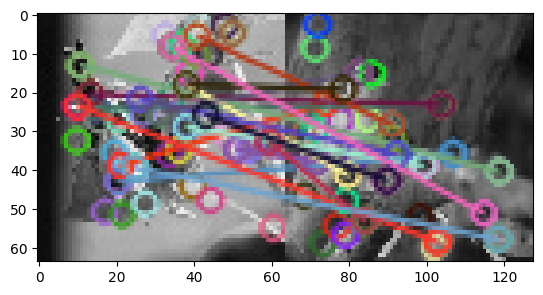

(<matplotlib.image.AxesImage at 0x7f456a863cd0>, None)

In [ ]:
import matplotlib.pyplot as  plt

# Select two images
image1 = images_train[1003]  # Replace with your image
image2 = images_train[1004]  # Replace with your image

# Extract features
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Create BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=0)


plt.imshow(matched_image),plt.show()


In [ ]:
descriptors_list = [extract_features(image) for image in images_train]

# Remove None values from descriptors_list
descriptors_list = [descriptors for descriptors in descriptors_list if descriptors is not None]

descriptors_list = [desc.astype(np.float32) for desc in descriptors_list if desc is not None]

# Before fitting the model, you can check the dtypes of your descriptors to make sure they are float32:
for desc in descriptors_list:
    if desc.dtype != np.float32:
        print(f"Unexpected dtype: {desc.dtype}")


In [ ]:
num_clusters = 100
kmeans = MiniBatchKMeans(n_clusters=num_clusters)
classifier = SVC(kernel='linear')

# Transform descriptors to features
def transform_bovw(descriptors_list, kmeans, num_clusters):
    bovw_features = []
    for descriptors in descriptors_list:
        histogram = np.zeros(num_clusters)
        if descriptors is not None:
            predicted_cluster = kmeans.predict(descriptors)
            for i in predicted_cluster:
                histogram[i] += 1
        bovw_features.append(histogram)
    return bovw_features

# Fit the model
def fit_bovw(descriptors_list, labels, kmeans, classifier):
    all_descriptors = np.vstack(descriptors_list)
    kmeans.fit(all_descriptors)
    features = transform_bovw(descriptors_list, kmeans, num_clusters)
    classifier.fit(features, labels)

# Predict classes
def predict_bovw(descriptors_list, kmeans, classifier, num_clusters):
    features = transform_bovw(descriptors_list, kmeans, num_clusters)
    return classifier.predict(features)

In [ ]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(descriptors_list, train_labels, test_size=0.2, random_state=42)


In [ ]:
# Training
fit_bovw(X_train, y_train, kmeans, classifier)

# Validation
y_pred = predict_bovw(X_val, kmeans, classifier, num_clusters)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Validation Accuracy: 0.0597


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Compute confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Compute precision, recall, and f1-score
clf_report = classification_report(y_val, y_pred)
print("Classification Report:")
print(clf_report)


Confusion Matrix:
[[17  0  0 ...  1  0  1]
 [ 3 12  1 ...  0  2  2]
 [ 3  5  1 ...  1  3  3]
 ...
 [ 1  3  0 ...  4  4  1]
 [ 3  1  0 ...  1 10  6]
 [ 5  0  0 ...  0  1 30]]
Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.09      0.06       200
           1       0.06      0.06      0.06       189
           2       0.02      0.00      0.01       217
           3       0.05      0.03      0.03       195
           4       0.06      0.03      0.04       190
           5       0.04      0.04      0.04       186
           6       0.05      0.03      0.03       221
           7       0.05      0.05      0.05       194
           8       0.00      0.00      0.00       220
           9       0.03      0.04      0.03       193
          10       0.00      0.00      0.00       200
          11       0.02      0.02      0.02       210
          12       0.03      0.01      0.02       211
          13       0.01      0.01      0.01   

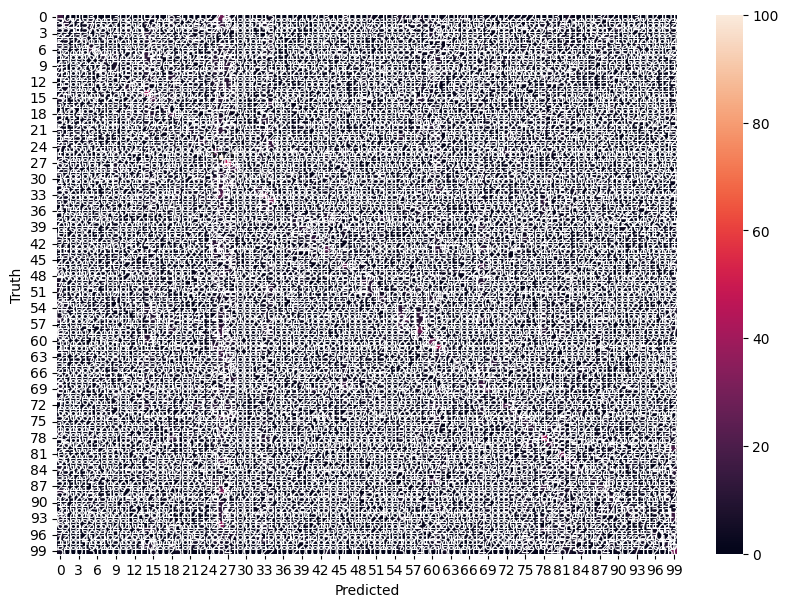

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using Seaborn's heatmap to visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## 3. Convolutional Neural Networks: The student should train a convolutional neural network (CNN) on the preprocessed images to classify them into different categories. The student should experiment with different architectures such as VGG, ResNet, Inception, etc.





In [ ]:

trainloader =DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)


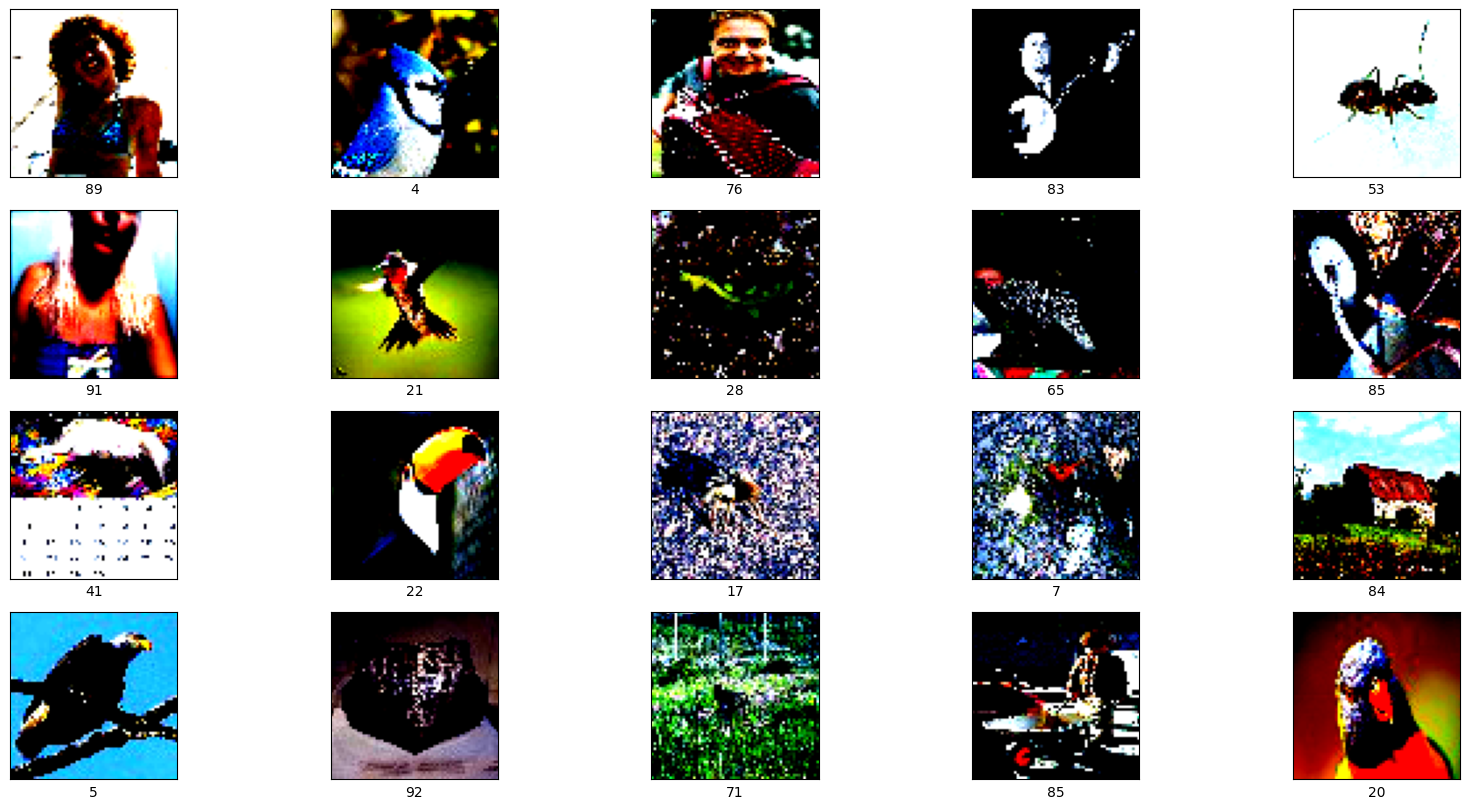

In [ ]:
iterator = iter(trainloader)
x, y = next(iterator)


a = train_dataset.class_indices
class_names = train_dataset.labels

def plot_images(images, labels):
    plt.figure(figsize=(20,10)) # define your figure size
    for i in range(20): # this will draw 20 images
        plt.subplot(4,5,i+1) # define your subplot
        plt.xticks([]) # remove x-axis markings
        plt.yticks([]) # remove y-axis markings
        plt.grid(False)
        image = images[i].permute(1, 2, 0)  # rearrange dimensions to (height, width, channels)
        plt.imshow(image.numpy()) # plot the image
        plt.xlabel(labels[i].numpy())  # assign correct label for each image
    plt.show()

images, labels = next(iter(trainloader))
plot_images(images, labels)


In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y,transform=None):
        self.img_labels = y
        self.img_names = X
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_names[idx]
        image = Image.open(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        label=torch.tensor(label)

        return image, label

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
 )])

transform_val = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
 )])

dataset = ImageDataset(train_img_paths, train_labels, transform=transform_train)
#val_dataset = ImageDataset(val_img_paths, val_labels,transform=transform_val)
train_length=int(0.7* len(dataset))

test_length=len(dataset)-train_length
train_dataset,test_dataset=torch.utils.data.random_split(dataset,(train_length,test_length))

dataloader_train=torch.utils.data.DataLoader(train_dataset,
        batch_size=10, shuffle=True)
dataloader_test=torch.utils.data.DataLoader(test_dataset,
        batch_size=10, shuffle=False)


VGG19

In [ ]:
import torchvision
import torch.nn as nn

net=torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1') #weights=None for random weights **********
print(net)
num_ftrs = net.classifier[0].in_features
# Here the size of each output sample is set to 1.
net.classifier = nn.Sequential(nn.Linear(num_ftrs, 512),
                               nn.ReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(512,256),
                               nn.ReLU(),
                               nn.Linear(256, 128),
                               nn.ReLU(),
                               nn.Linear(128,100)
                               )
print("*******************************************")
print(net)
net = net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from scipy.stats import spearmanr, pearsonr
import itertools
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)


In [ ]:
from torchsummary import summary
summary(net, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [ ]:
train_losses=[]
train_accuracy=[]
net.train()
train_loss=0.0
correct=0
total=0

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()#accumulated gradient is set to zero after the  epoch

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # # print statistics
        # running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0
        running_loss += loss.item() # Add the loss
        _, predicted = outputs.max(1) # Get the predicted label
        total += labels.size(0) # Get the total
        correct += predicted.eq(labels.squeeze()).sum().item()

loss/=len(dataloader_test)
test_accurate=correct/total
train_losses.append(loss)
train_accuracy.append(test_accurate)

print(f'test accuracy:{train_accuracy}')

print(f'test loss:{train_losses}')

print('Finished Training')

test accuracy:[0.38061428571428574]
test loss:[tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)]
Finished Training


In [ ]:
test_losses=[]
test_accuracy=[]
net.eval()
test_loss=0.0
correct=0
total=0

dataiter = iter(dataloader_test)
images=[]
#for i in range(len(dataloader_test)):
#image, label = next(dataiter)
  #images.append(image)
with torch.no_grad():
  for image, label in dataloader_test:
    image=image.to(device)
    label=label.to(device)
    output=net(image)
    _, pred= output.max(1)
    loss=criterion(output,label.squeeze())
    test_loss=loss.item()
    total+=label.size(0)
    correct+=pred.eq(label.squeeze()).sum().item()

test_loss/=len(dataloader_test)
test_accurate=correct/total
test_losses.append(test_loss)
test_accuracy.append(test_accurate)

print(f'test accuracy:{test_accuracy}')

print(f'test loss:{test_losses}')


test accuracy:[0.5341333333333333]
test loss:[0.0008333070278167725]


In [ ]:
import random
class_name=[str(i) for i in range(100)]

net.eval()

for _ in range(20):
  index=random.randint(0,len(test_dataset)-1)
  image,label=test_dataset[index]
  image=image.to(device)


  with torch.no_grad():
    output=net(image.unsqueeze(0))
    class_pred=torch.argmax(output).item()


predicted_label=class_name[class_pred]
og_label=class_name[class_pred]



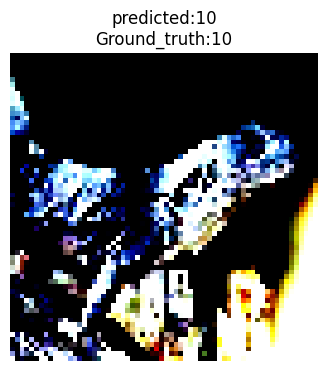

In [ ]:
img=image.cpu()
plt.figure(figsize=(4,4))
plt.imshow(img.permute(1,2,0))
plt.title(f'predicted:{predicted_label}\nGround_truth:{og_label}')
plt.axis('off')
plt.show()

## Resnet-50

In [ ]:
net1=torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2') #weights=None for random weights **********
print(net1)
num_ftrs = 2048
# Here the size of each output sample is set to 1.
net1.classifier = nn.Sequential(nn.Linear(num_ftrs, 512),
                               nn.GELU(),
                               nn.Dropout(0.2),
                               nn.Linear(512,256),
                               nn.GELU(),
                               nn.Linear(256, 128),
                               nn.GELU(),
                               nn.Linear(128,100)
                               )
print("*******************************************")
print(net1)
net1 = net1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchsummary import summary
summary(net1, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
net1.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()#accumulated gradient is set to zero after the  epoch

        # forward + backward + optimize
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    # scheduler.step()
print('Finished Training')

In [ ]:
test_losses=[]
test_accuracy=[]
net1.eval()
test_loss=0.0
correct=0
total=0

dataiter = iter(dataloader_test)
images=[]

with torch.no_grad():
  for image, label in dataloader_test:
    image=image.to(device)
    label=label.to(device)
    output=net1(image)
    _, pred= output.max(1)
    loss=criterion(output,label.squeeze())
    total+=label.size(0)
    correct+=pred.eq(label.squeeze()).sum().item()

loss/=len(dataloader_test)
test_accurate=correct/total
test_losses.append(loss)
test_accuracy.append(test_accurate)

print(f'test accuracy:{test_accuracy}')

print(f'test loss:{test_losses}')


In [ ]:
import random
class_name=[str(i) for i in range(100)]

net1.eval()

for _ in range(20):
  index=random.randint(0,len(test_dataset)-1)
  image,label=test_dataset[index]
  image=image.to(device)


  with torch.no_grad():
    output=net(image.unsqueeze(0))
    class_pred=torch.argmax(output).item()


predicted_label=class_name[class_pred]
og_label=class_name[class_pred]


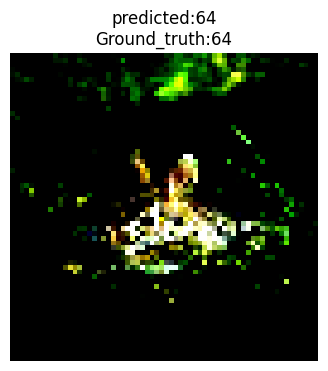

In [ ]:
img=image.cpu()
plt.figure(figsize=(4,4))
plt.imshow(img.permute(1,2,0))
plt.title(f'predicted:{predicted_label}\nGround_truth:{og_label}')
plt.axis('off')
plt.show()

Accuracy: 52.66%
              precision    recall  f1-score   support

           0       0.44      0.61      0.51       295
           1       0.90      0.77      0.83       291
           2       0.62      0.73      0.67       295
           3       0.76      0.76      0.76       360
           4       0.80      0.71      0.75       303
           5       0.72      0.44      0.55       280
           6       0.27      0.36      0.31       304
           7       0.71      0.73      0.72       315
           8       0.52      0.51      0.52       306
           9       0.60      0.65      0.63       273
          10       0.31      0.17      0.22       298
          11       0.49      0.51      0.50       295
          12       0.54      0.45      0.49       285
          13       0.45      0.34      0.39       273
          14       0.44      0.52      0.48       293
          15       0.58      0.55      0.56       307
          16       0.25      0.27      0.26       290
          

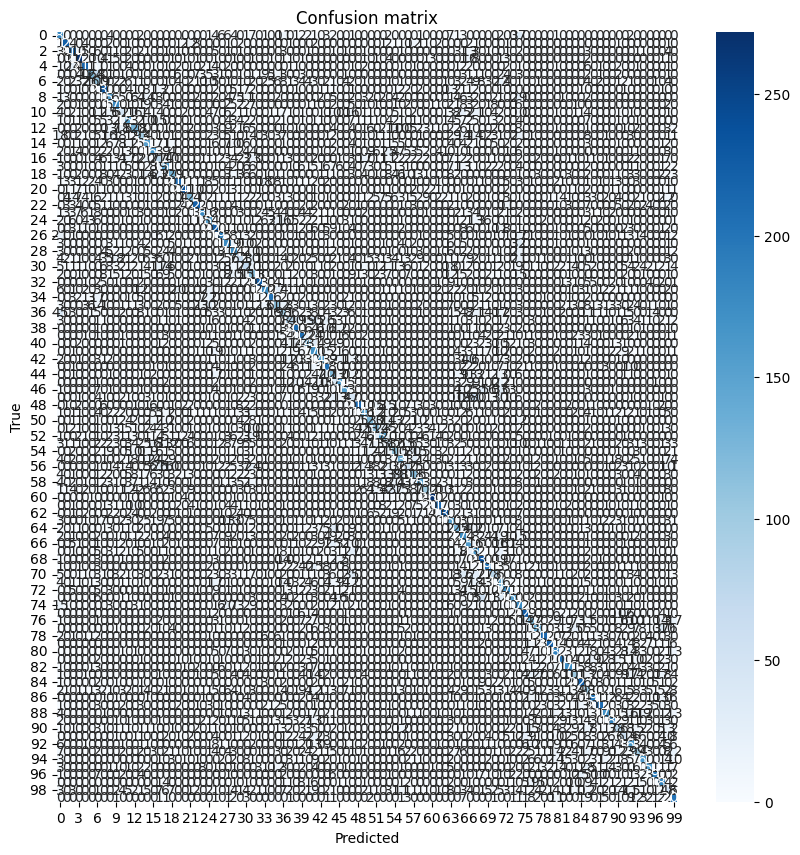

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict classes for the test set
net1.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = net1(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, f1-score
print(classification_report(all_labels, all_preds))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()


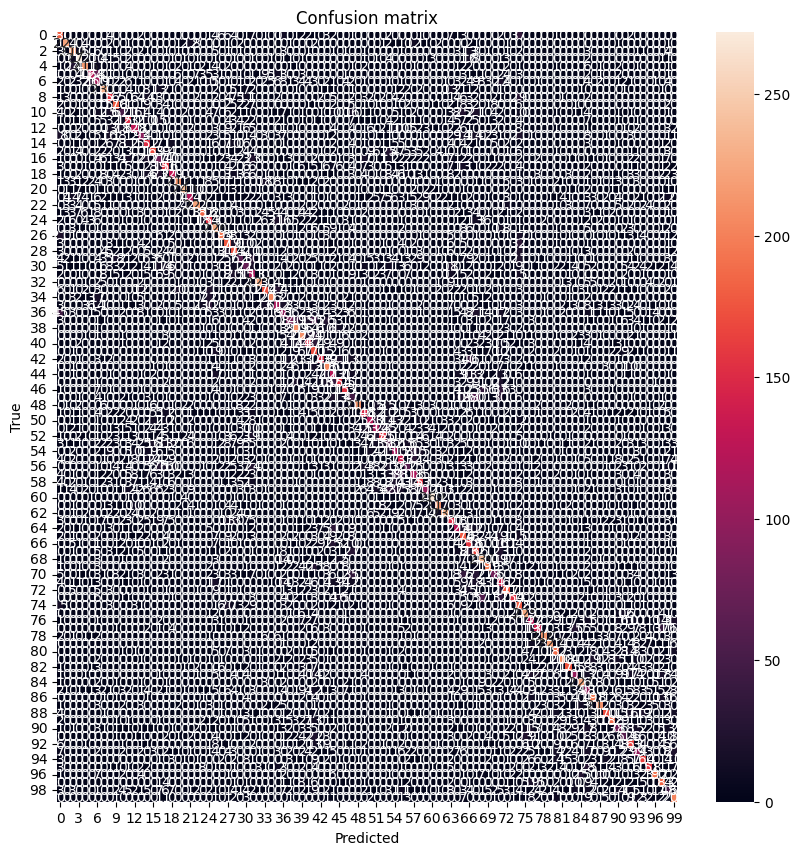

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

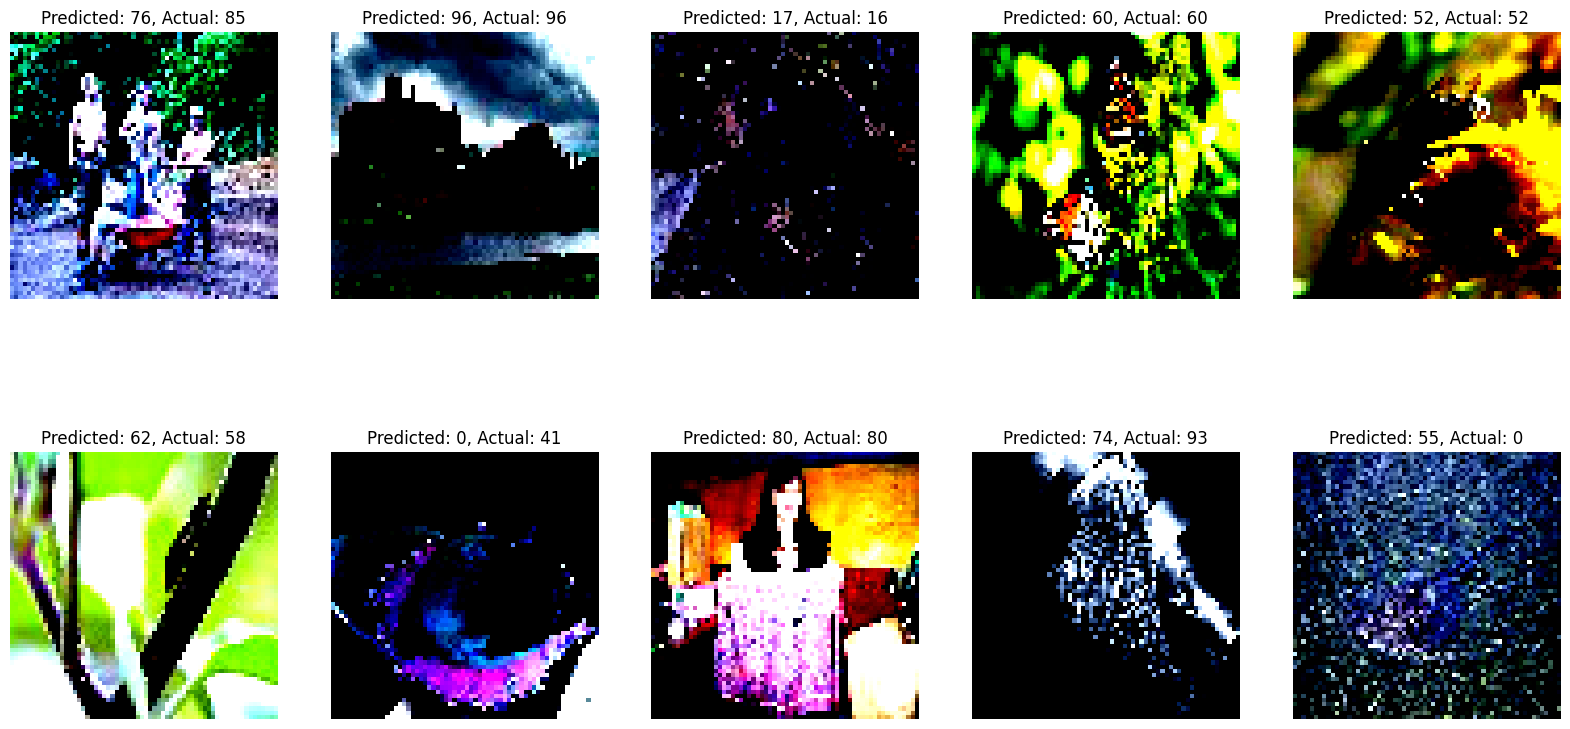

In [ ]:
import matplotlib.pyplot as plt

# Get 20 images from the test set
images, labels = next(iter(dataloader_test))

# Move them to the device
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = net(images)
_, preds = torch.max(outputs, 1)

# Move images and labels back to CPU for plotting
images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

# Unnormalize the images

images = images.clip(0, 1)

# Plot the images with their predicted and actual labels
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].transpose((1, 2, 0)))
    plt.title(f"Predicted: {preds[i]}, Ground_truth: {labels[i]}")
    plt.axis('off')
plt.show()


# 6. Hyperparameter Tuning: fine-tune the hyperparameters of the models to achieve better performance by changing the optimizer from Adam to SGD

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.0001,momentum=0.9)

In [ ]:
net.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()#accumulated gradient is set to zero after the  epoch

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.387
[1,  4000] loss: 0.434
[1,  6000] loss: 0.430
[2,  2000] loss: 0.347
[2,  4000] loss: 0.368
[2,  6000] loss: 0.393
[3,  2000] loss: 0.307
[3,  4000] loss: 0.327
[3,  6000] loss: 0.356
[4,  2000] loss: 0.275
[4,  4000] loss: 0.297
[4,  6000] loss: 0.311
[5,  2000] loss: 0.235
[5,  4000] loss: 0.254
[5,  6000] loss: 0.273
[6,  2000] loss: 0.224
[6,  4000] loss: 0.234
[6,  6000] loss: 0.247
[7,  2000] loss: 0.194
[7,  4000] loss: 0.213
[7,  6000] loss: 0.212
[8,  2000] loss: 0.176
[8,  4000] loss: 0.191
[8,  6000] loss: 0.189
[9,  2000] loss: 0.156
[9,  4000] loss: 0.169
[9,  6000] loss: 0.175
[10,  2000] loss: 0.141
[10,  4000] loss: 0.148
[10,  6000] loss: 0.159
Finished Training


In [ ]:
test_losses=[]
test_accuracy=[]
net.eval()
test_loss=0.0
correct=0
total=0

dataiter = iter(dataloader_test)
images=[]


with torch.no_grad():
  for image, label in dataloader_test:
    image=image.to(device)
    label=label.to(device)
    output=net(image)
    _, pred= output.max(1)
    loss=criterion(output,label.squeeze())
    test_loss+=loss.item()
    total+=label.size(0)
    correct+=pred.eq(label.squeeze()).sum().item()

test_loss/=len(dataloader_test)
test_accurate=correct/total
test_losses.append(test_loss)
test_accuracy.append(test_accurate)

print(f'test accuracy:{test_accuracy}')

print(f'test loss:{test_losses}')


test accuracy:[0.6847666666666666]
test loss:[1.9056499946726642]


Accuracy: 68.75%
              precision    recall  f1-score   support

           0       0.78      0.68      0.72       281
           1       0.88      0.91      0.90       277
           2       0.79      0.71      0.75       298
           3       0.79      0.82      0.81       300
           4       0.76      0.85      0.81       277
           5       0.82      0.69      0.75       292
           6       0.50      0.64      0.57       270
           7       0.87      0.81      0.84       309
           8       0.81      0.49      0.61       300
           9       0.76      0.67      0.71       312
          10       0.46      0.41      0.43       303
          11       0.60      0.67      0.64       291
          12       0.58      0.59      0.59       298
          13       0.67      0.55      0.60       294
          14       0.84      0.71      0.77       304
          15       0.67      0.74      0.70       307
          16       0.49      0.52      0.50       305
          

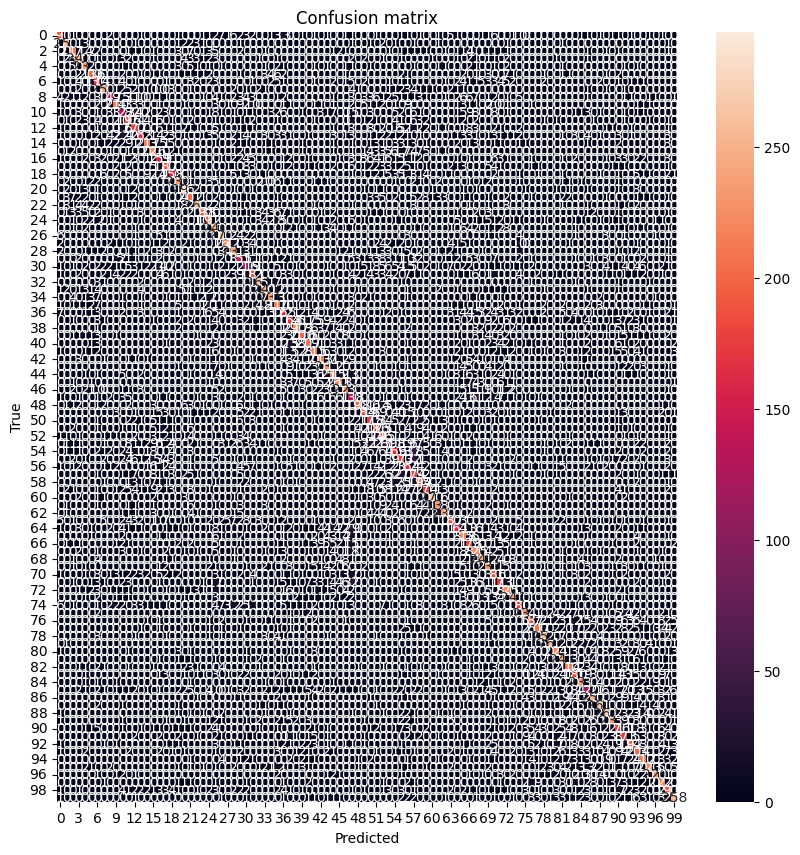

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict classes for the test set
net.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, f1-score
print(classification_report(all_labels, all_preds))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()
